**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [3]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [9]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.__k_neighbors = n_neighbors
        self.__algorithm = algorithm
        self.__metric = metric
        
        self.__features = np.array([])
        self.__targets = np.array([])
    
    def fit(self, X, y):
        self.__features = np.asarray(X)
        self.__targets = np.asarray(y)
    
    def predict(self, X):
        pred_targets = np.apply_along_axis(lambda x: self.__vote(x), 1, X).argmax(axis=1)
        
        return pred_targets
    
    def __vote(self, x):
        if self.__algorithm == 'brute':
            distances = distance.cdist(x[np.newaxis, :], self.__features, metric=self.__metric)[0]
            weights = 1.0 / distances
            best_indices = np.argpartition(weights, -self.__k_neighbors)[-self.__k_neighbors:]
            best_weights = weights[best_indices]
            
        elif self.__algorithm == 'kd_tree':
            tree = KDTree(self.__features, leaf_size=2, metric=self.__metric)
            best_distances, best_indices = tree.query(x[np.newaxis, :], self.__k_neighbors)
            best_indices = best_indices[0]
            best_weights = 1.0 / best_distances[0]
        
        best_targets = self.__targets[best_indices]
        
        return np.bincount(best_targets, minlength=self.__targets.max()+1, weights=best_weights)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [204]:
iris = datasets.load_iris()

In [205]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135, 4), (15, 4), (135,), (15,))

In [206]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [207]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [208]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"
#my_clf_pred, sklearn_pred
#accuracy_score(y_test, my_clf_pred), accuracy_score(y_test, sklearn_pred )

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [209]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [210]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [211]:
%time clf.predict(X_test)

Wall time: 1.97 ms


array([1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 1, 0, 1, 1])

In [212]:
%time my_clf.predict(X_test)

Wall time: 1.99 ms


array([1, 2, 0, 2, 2, 0, 2, 1, 0, 2, 0, 1, 0, 1, 1], dtype=int64)

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [213]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [214]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [215]:
%time clf.fit(X_train, y_train)

Wall time: 998 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [216]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [217]:
%time clf.predict(X_test)

Wall time: 1.96 ms


array([0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1])

In [218]:
%time my_clf.predict(X_test)

Wall time: 6.02 ms


array([0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 1], dtype=int64)

In [219]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [4]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [5]:
data = newsgroups['data']
target = newsgroups['target']
target.shape

(11314,)

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [15]:
vectorizer = CountVectorizer(stop_words='english', min_df=0.02)
X = vectorizer.fit_transform(data)
freqs = np.array(X.sum(axis=0)).ravel()
X = X.toarray()
freqs.shape

(451,)

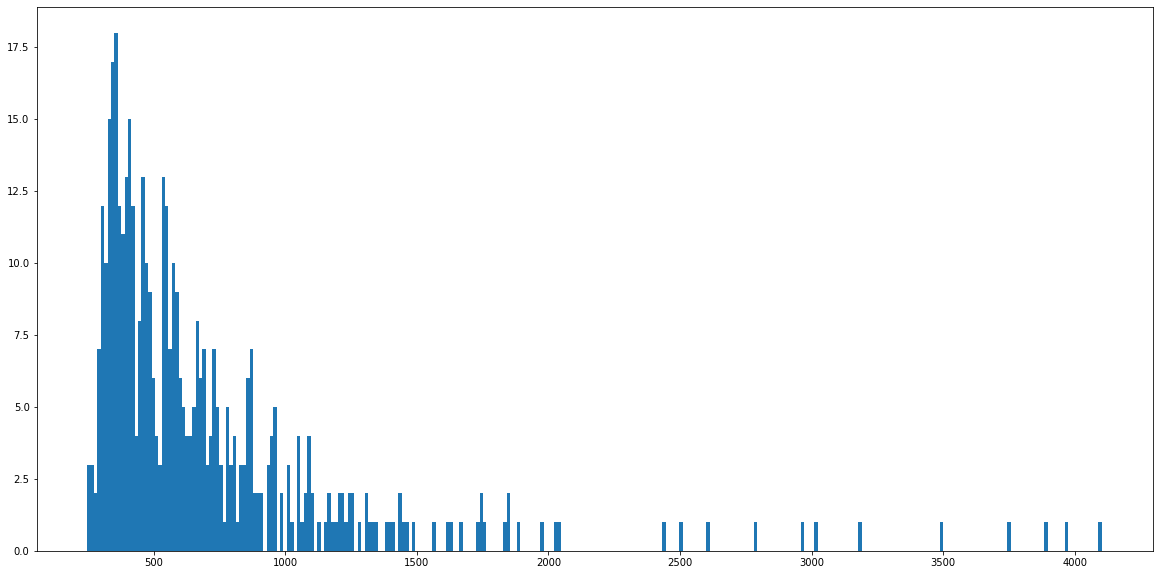

In [337]:
fig = plt.figure(figsize=(20, 10))
plt.hist(freqs, bins=300)
plt.show()

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [7]:
kf = KFold(n_splits=3)
type(kf)

sklearn.model_selection._split.KFold

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [16]:
scores = np.zeros((10, 3), dtype='float')

for n in range(1, 11):
    i = 0
    print(n)
    my_knn = MyKNeighborsClassifier(n_neighbors=n)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = target[train_index], target[test_index]
        
        my_knn.fit(X_train, y_train)
        my_pred = my_knn.predict(X_test)
        
        scores[n - 1, i] = accuracy_score(y_test, my_pred)
        i += 1
    
scores = scores.mean(axis=1)
scores

1


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


2
3
4
5
6
7
8
9
10


array([0.21018207, 0.21000495, 0.21522015, 0.21990509, 0.22078856,
       0.22273292, 0.22600336, 0.2290084 , 0.23095281, 0.22909677])

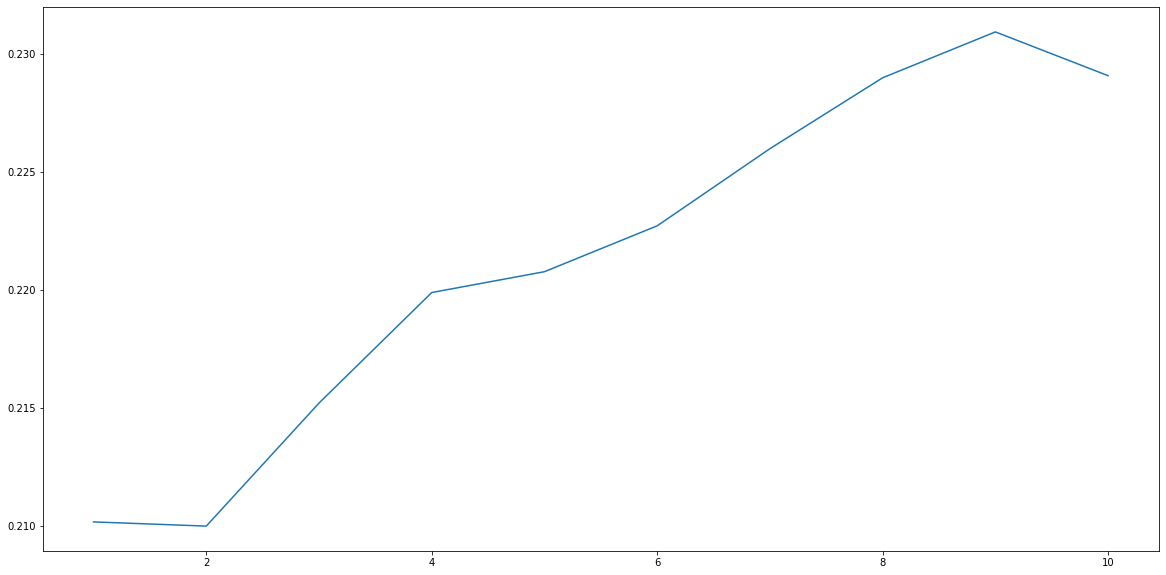

In [17]:
ns = np.arange(1, 11)
plt.figure(figsize=(20, 10))
sns.lineplot(ns, scores)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [ ]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.